In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/home/wanhr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_ip = "10.215.173.1"
dl_pkts = np.zeros([0, 3])
ul_pkts = np.zeros([0, 3])

for i in [2]:
  filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_{}.csv".format(i)

  df = load_csv(filename)
  # stats_src_ip(df)
  # stats_dst_ip(df)
  dl_data = extract_dl_pkt_interval_time(df, local_ip)
  ul_data = extract_ul_pkt_interval_time(df, local_ip)
  dl_pkts = np.concatenate((dl_pkts, dl_data), axis=0)
  ul_pkts = np.concatenate((ul_pkts, ul_data), axis=0)
  print(dl_pkts.shape)
  print(ul_pkts.shape)
  # dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
  # ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

FONT_SIZE = 35
plt.rcParams["font.size"] = FONT_SIZE


(4092384, 3)
(562975, 3)


In [3]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=1000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=1000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

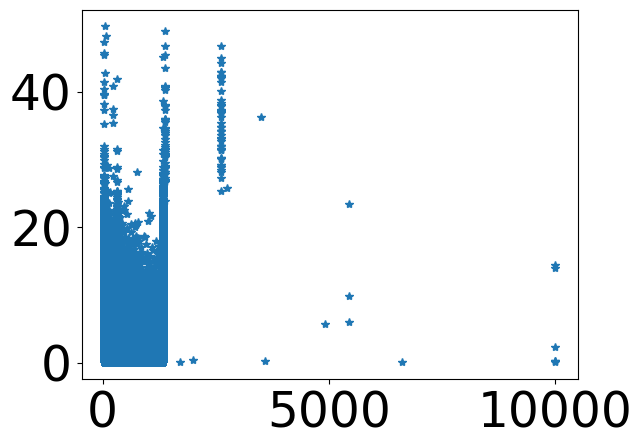

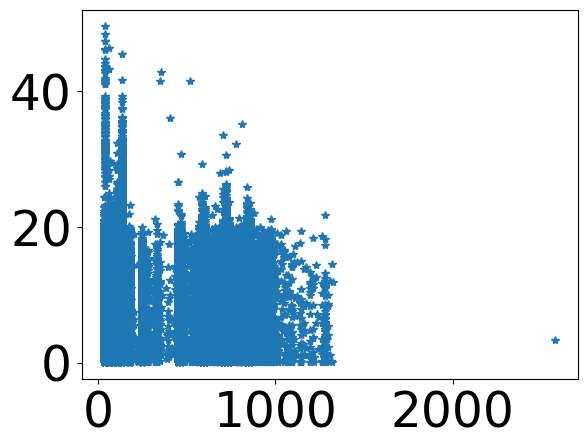

In [4]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

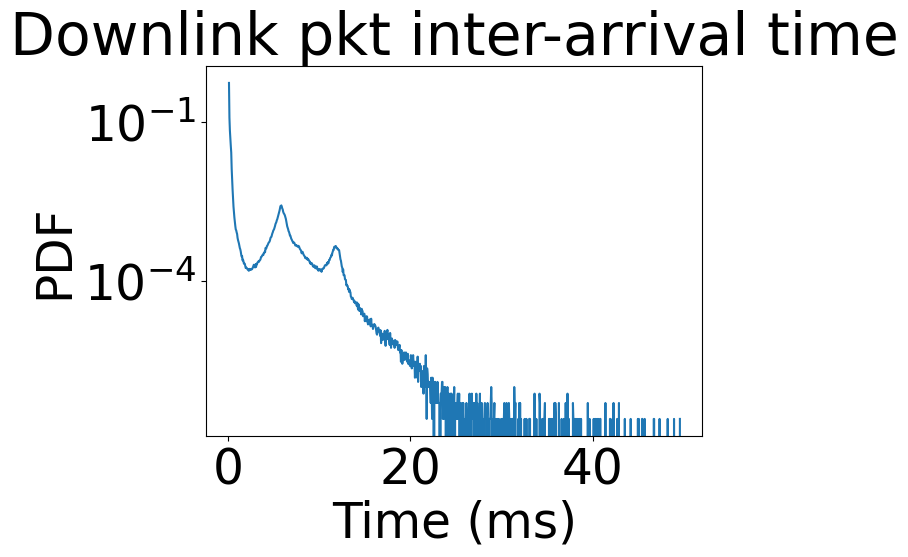

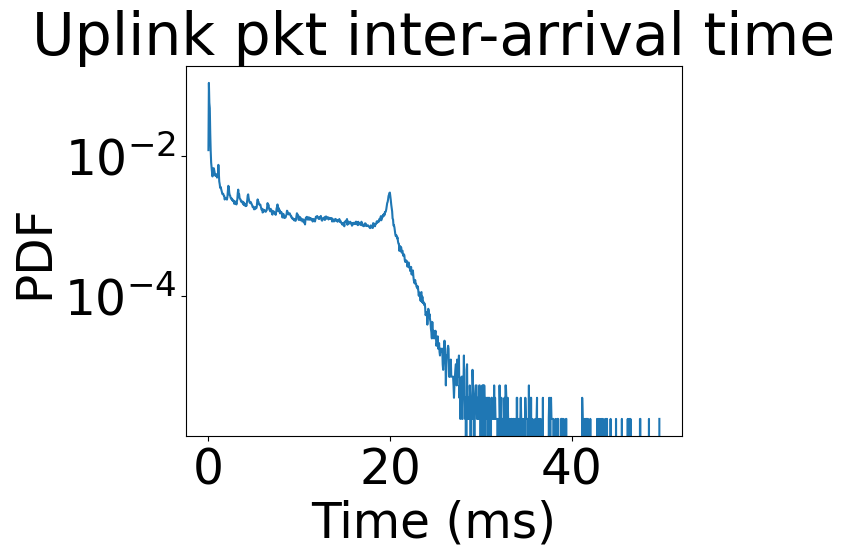

In [5]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [6]:
train = torch.tensor(ul_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

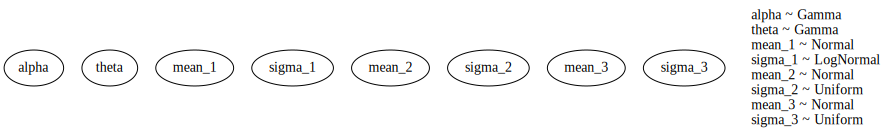

In [7]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    mean_3 = pyro.sample("mean_3", dist.Normal(20, 2))
    sigma_3 = pyro.sample("sigma_3", dist.Uniform(0., 0.05))
    gaussian_3 = dist.Normal(mean_3, sigma_3)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    gaussian_samp_3 = gaussian_3.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [8]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    mean_3_loc = pyro.param('mean_3_loc', lambda: torch.tensor(12. ))
    sigma_3_loc = pyro.param('sigma_3_loc', lambda: torch.tensor(0.))
    mean_3 = pyro.sample('mean_3', dist.Normal(mean_3_loc, torch.tensor(0.05)))
    sigma_3 = pyro.sample('sigma_3', dist.LogNormal(sigma_3_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2, 'mean_3': mean_3, 'sigma_3': sigma_3}

In [9]:
def guide_map(pkt_size, pkt_interval=None):
  alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.unit_interval)
  alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

  theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

  mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
  mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
  sigma_1 = pyro.sample('sigma_1', dist.Uniform(0, torch.tensor(0.005)))

  mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
  mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
  sigma_2 = pyro.sample('sigma_2', dist.Uniform(0, torch.tensor(0.005)))

  mean_3_loc = pyro.param('mean_3_loc', lambda: torch.tensor(20. ))
  mean_3 = pyro.sample('mean_3', dist.Normal(mean_3_loc, torch.tensor(0.05)))
  sigma_3 = pyro.sample('sigma_3', dist.Uniform(0, torch.tensor(0.005)))

  # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
  #                       constraint=constraints.positive)
  # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
  # y = pyro.sample('y', cat)

  return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
          'mean_2': mean_2, 'sigma_2': sigma_2, 'mean_3': mean_3, 'sigma_3': sigma_3}

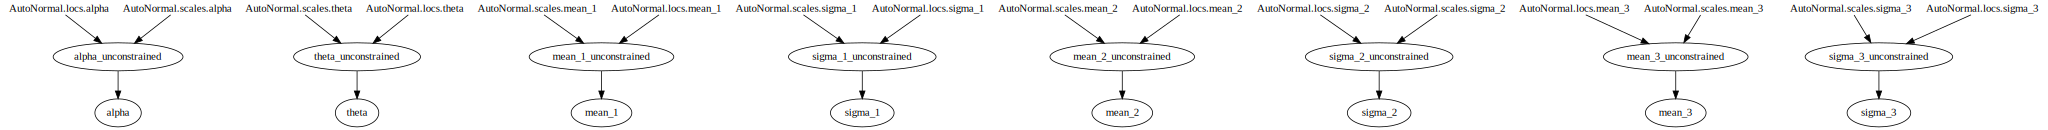

In [10]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [11]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide_map, adam, elbo)

Step: 0, Elbo loss: 5981.346028923988
Step: 100, Elbo loss: 7936.577384531498
Step: 200, Elbo loss: 11534.816758334637
Step: 300, Elbo loss: 6951.217673540115
Step: 400, Elbo loss: 13390.616560548544
Step: 500, Elbo loss: 6214.570626370609
Step: 600, Elbo loss: 6048.689272522926
Step: 700, Elbo loss: 8568.42125493288
Step: 800, Elbo loss: 5859.071184456348
Step: 900, Elbo loss: 7530.693029716611
Step: 1000, Elbo loss: 8316.426338493824
Step: 1100, Elbo loss: 11783.000669300556
Step: 1200, Elbo loss: 10473.534165049903
Step: 1300, Elbo loss: 7218.0069851875305
Step: 1400, Elbo loss: 6979.982576489449
Step: 1500, Elbo loss: 8301.895199999213
Step: 1600, Elbo loss: 6684.521101772785
Step: 1700, Elbo loss: 8218.66485966742
Step: 1800, Elbo loss: 8740.62081682682
Step: 1900, Elbo loss: 12402.552076458931
Step: 2000, Elbo loss: 6390.021866440773
Step: 2100, Elbo loss: 10079.698756486177
Step: 2200, Elbo loss: 5864.647065997124
Step: 2300, Elbo loss: 6044.29257017374
Step: 2400, Elbo loss: 58

Text(0, 0.5, 'ELBO loss')

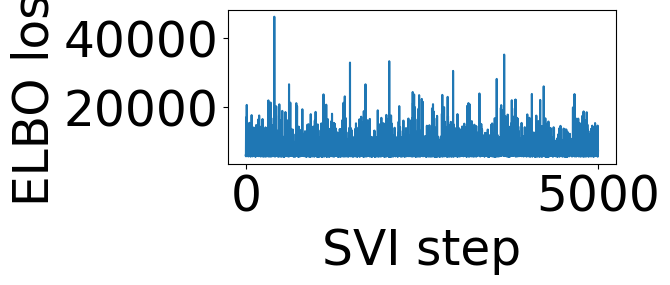

In [12]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide_map, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

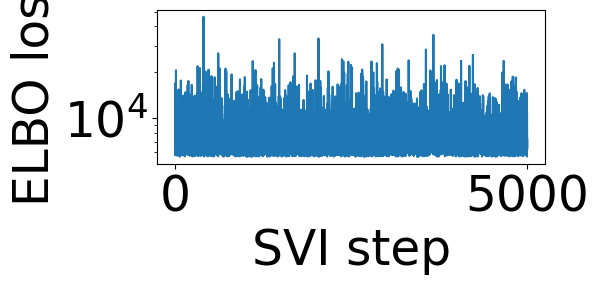

In [13]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [14]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_alpha 0.9999999
alpha_theta 0.99999964
theta_alpha 0.9999999
theta_theta 0.9999993
mean_1_loc 5.0018907
mean_2_loc 11.996132
mean_3_loc 19.972483


In [15]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  gaussian_samp_3 = dist.Normal(svi_samples['mean_3'][0], svi_samples['sigma_3'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3)
  
print(res)

[tensor(0.0703), tensor(0.1501), tensor(0.7137), tensor(0.0977), tensor(-0.0749), tensor(1.0432), tensor(-0.0411), tensor(1.1129), tensor(0.6412), tensor(1.5975), tensor(1.0288), tensor(0.3783), tensor(0.1904), tensor(-0.1761), tensor(-0.1040), tensor(0.0386), tensor(-0.0270), tensor(-0.5425), tensor(0.4369), tensor(0.4589), tensor(0.2757), tensor(0.1781), tensor(0.6410), tensor(1.1534), tensor(0.5299), tensor(0.2850), tensor(-0.0068), tensor(0.0584), tensor(0.1139), tensor(0.7359), tensor(0.5773), tensor(0.1867), tensor(-0.8831), tensor(0.6906), tensor(0.1555), tensor(0.0593), tensor(0.0778), tensor(0.1607), tensor(1.3373), tensor(0.2155), tensor(0.0654), tensor(1.3761), tensor(0.9683), tensor(1.7452), tensor(1.6358), tensor(0.2789), tensor(0.1267), tensor(-0.6800), tensor(0.3744), tensor(-0.0039), tensor(0.6362), tensor(0.7717), tensor(-0.0061), tensor(0.4991), tensor(0.0154), tensor(1.3562), tensor(1.9256), tensor(1.1377), tensor(0.9960), tensor(1.0645), tensor(1.6263), tensor(-0.10

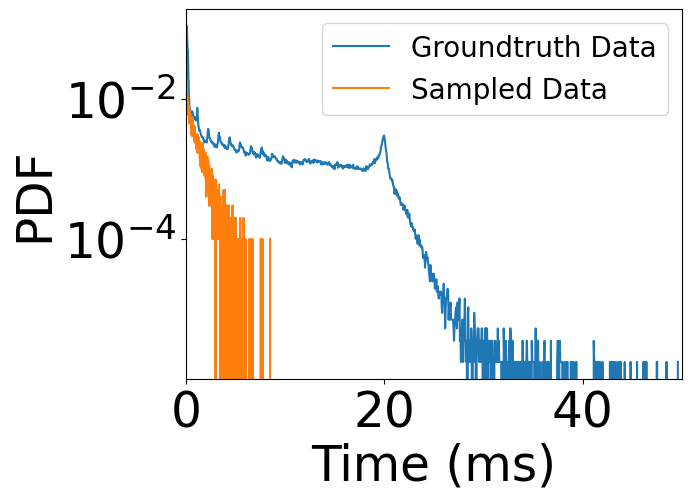

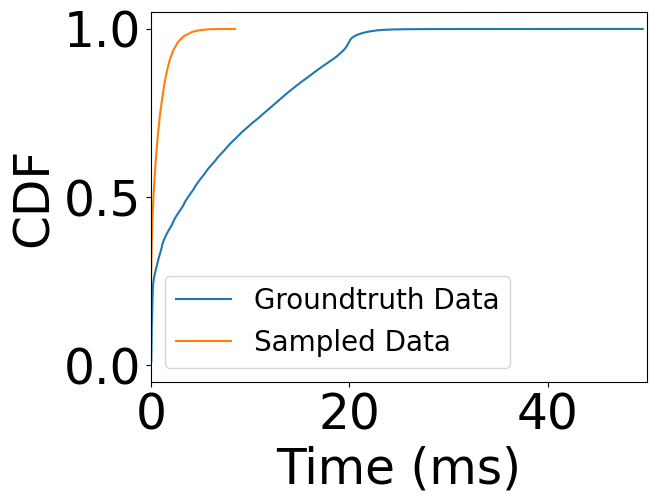

In [16]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf, label="Groundtruth Data")
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")

# plt.figure()
plt.plot(res_bins_count[1:], res_pdf, label="Sampled Data")
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.legend(prop={'size': 20})

plt.figure()
plt.plot(ul_bins_count[1:], ul_cdf, label="Groundtruth Data")
# plt.yscale("log")

# plt.figure()
plt.plot(res_bins_count[1:], res_cdf, label="Sampled Data")
# plt.yscale("log")
plt.xlim([0, 50])
plt.xlabel("Time (ms)")
plt.ylabel("CDF")

plt.legend(prop={'size': 20})

plt.show()